In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets, cluster, mixture
from time import time
import warnings
# uncleear cute discuss
# explain your dataset about clear cute 
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import torch
import torch.nn as nn
import copy
from PIL import Image
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from model.vae_model import VAutoencoder
from model.predict_reconstruct import RNN_VAE
import torch
import cv2
import numpy as np
from matplotlib import pyplot as plt
import mediapipe as mp
from sklearn import manifold
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
%matplotlib inline

2024-07-01 14:45:23.144781: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-01 14:45:31.438206: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
sequence_length = 30
input_size = 66
hidden_size = 512#64#1024
num_layers = 2
batch_size = sequence_length # set to the number of images of a seqence # 36
num_epoches = 300
learning_rate = 0.01
latent_zz = 16
device = torch.device('cuda' if torch.cuda.is_available else'cpu')

In [4]:
data_path = "/home/wetu/bmo/Thesis_Research/keypoints_array.npy"
keypoints = np.load(data_path)
print(keypoints.shape)
keypoints = keypoints.reshape(-1,66)
scaler = MinMaxScaler()

# Fit scaler on the data
scaler.fit(keypoints)

# Normalize the data
normalized_data = scaler.transform(keypoints)

(47742, 33, 2)


In [5]:
#keypoints using MP holistics
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils
# create meiapip detection function
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results
#draw landmarks
def draw_styled_landmarks(image, results):
    '''mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             )
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )'''
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )
    return image
import numpy as np

def extract_keypoints(results):
    # Extracts x and y coordinates if pose landmarks are available
    if results.pose_landmarks:
        pose = np.array([[res.x, res.y] for res in results.pose_landmarks.landmark]).flatten()
    else :
        pose = np.zeros(66)
    return pose


In [3]:
model = VAutoencoder(INPUT_SIZE=input_size,HIDDEN_SIZE=hidden_size,LATENT_SIZE=latent_zz,NUM_LAYERS=num_layers,seq_len=sequence_length,DROP_ENC=0.5,DROP_DEC=0.5)
model.to(device)
print(model)

/home/wetu/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


VAutoencoder(
  (encoder): Encoder(
    (encoder_rnn): GRU(66, 512, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  )
  (latent_lam): Lambda(
    (hid2mean): Linear(in_features=2048, out_features=16, bias=True)
    (hid2var): Linear(in_features=2048, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (rnn_rec): GRU(16, 512, batch_first=True, dropout=0.5, bidirectional=True)
    (latent_hid): Linear(in_features=16, out_features=1024, bias=True)
    (output_layer): Linear(in_features=1024, out_features=66, bias=True)
  )
)


In [6]:
n_components = 2
perplexity =30

in_dir = "/home/wetu/bmo/Thesis_Research/keypoint_hidden_arrayvae.npy"
#in_dir = "keypoint_hidden_arrayvae.npy"
movements = np.load(in_dir)
print(movements.shape)

tsne = manifold.TSNE(n_components=n_components, init='random', n_iter=5000,
                        random_state=0, perplexity=perplexity)
X = tsne.fit_transform(movements)


(8563, 16)


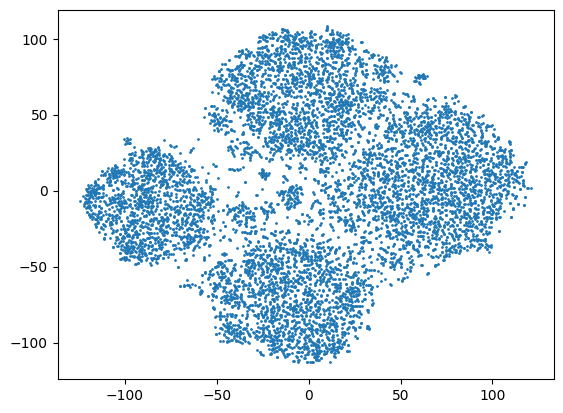

In [7]:
plt.scatter(X[:,0],X[:,1],s = 1)
plt.axis('tight')

plt.show()

Epoch 1/1000
27/27 [==============================] - 4s 22ms/step - loss: 0.5628 - val_loss: 0.2050
Epoch 2/1000
27/27 [==============================] - 0s 6ms/step - loss: 0.2179 - val_loss: 0.1330
Epoch 3/1000
27/27 [==============================] - 0s 6ms/step - loss: 0.1707 - val_loss: 0.1122
Epoch 4/1000
27/27 [==============================] - 0s 7ms/step - loss: 0.1500 - val_loss: 0.0996
Epoch 5/1000
27/27 [==============================] - 0s 6ms/step - loss: 0.1373 - val_loss: 0.0948
Epoch 6/1000
27/27 [==============================] - 0s 6ms/step - loss: 0.1276 - val_loss: 0.0896
Epoch 7/1000
27/27 [==============================] - 0s 6ms/step - loss: 0.1224 - val_loss: 0.0885
Epoch 8/1000
27/27 [==============================] - 0s 6ms/step - loss: 0.1167 - val_loss: 0.0863
Epoch 9/1000
27/27 [==============================] - 0s 6ms/step - loss: 0.1094 - val_loss: 0.0819
Epoch 10/1000
27/27 [==============================] - 0s 6ms/step - loss: 0.1067 - val_loss: 0.079

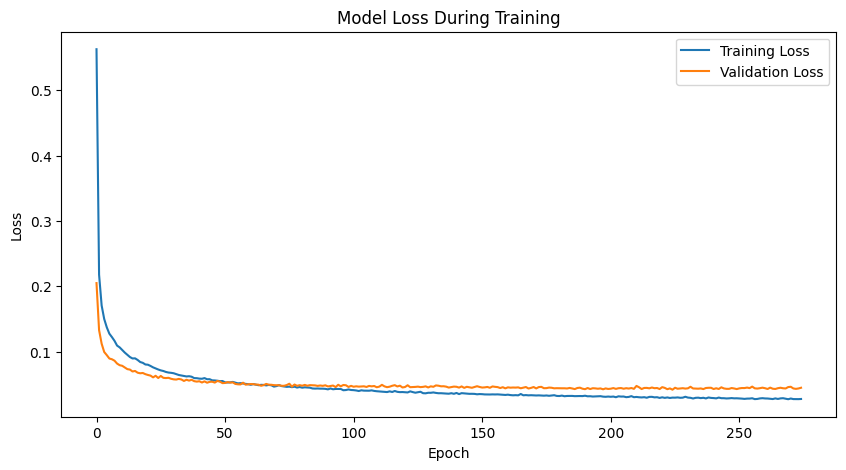

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

# Function to create the neural network model
def create_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(2)  # Output dimension is 2 for 2D visualization similar to t-SNE
    ])
    return model

# Setup your input dimension
input_dim = 16  # Example: 32 features in your high-dimensional data

# Create the model
nnmodel = create_model(input_dim)

# Prepare data scaling
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Assuming 'X_train' and 'Y_train_2d' are available
X_scaled = scaler_x.fit_transform(movements)
Y_scaled = scaler_y.fit_transform(X)  # Only scale if appropriate

# Compile the model with an optimized learning rate
nnmodel.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train the model with validation
history = nnmodel.fit(X_scaled, Y_scaled, epochs=1000, batch_size=256, validation_split=0.2, callbacks=[early_stopping])

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [10]:
# Assuming X_scaled is your input data and nnmodel is your model
map_t = []
for i in X_scaled:
    # Reshape your input to have shape (1, 32)
    i_reshaped = np.expand_dims(i, axis=0)
    t = nnmodel.predict(i_reshaped)
    map_t.append(t)


1/1 [==============================] - 0s 21ms/step


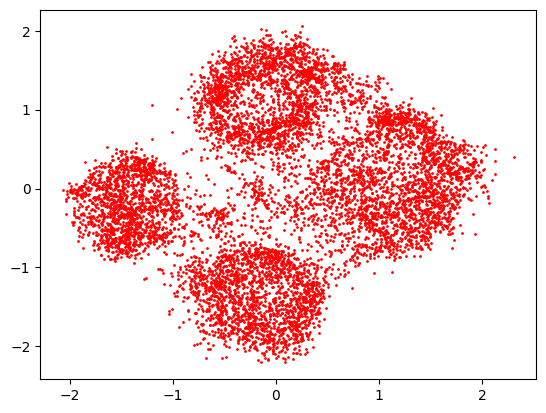

In [11]:
import numpy as np
import matplotlib.pyplot as plt
# Convert your list of predictions (which may be arrays or tensors) to a NumPy array
map_t_array = np.array([t.flatten() for t in map_t])
# Now you can use tuple-based indexing
plt.scatter(map_t_array[:, 0], map_t_array[:, 1],color ='red', s=1)
plt.show()

## Kmean

/home/wetu/anaconda3/envs/yolov7/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_46102/2197811540.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200,cmap='ranbow', alpha=0.5)


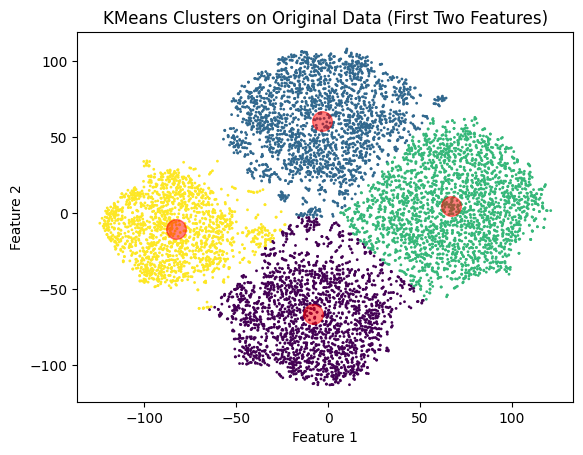

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Example: Creating a random dataset with shape (1102, 32)
# In practice, replace this with your actual data

# Optionally, you can also get the coordinates of the cluster centers
arr = X
# Apply KMeans clustering with k=5
kmeans = KMeans(n_clusters=4)
kmeans.fit(arr)
centers = kmeans.cluster_centers_
labels = kmeans.labels_

# Scatter plot of the original data
# The first two features (columns) are used for plotting
plt.scatter(arr[:, 0], arr[:, 1], c=labels, cmap='viridis',s=1)

# Plotting the centroids
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200,cmap='ranbow', alpha=0.5)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('KMeans Clusters on Original Data (First Two Features)')

# Display the plot
plt.show()


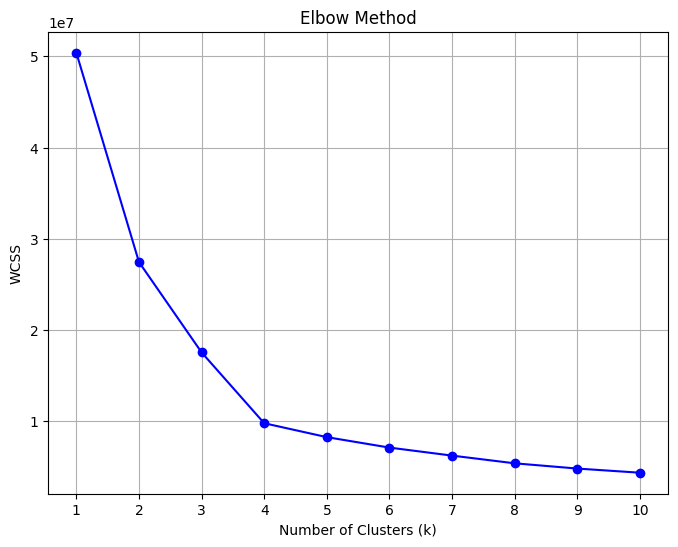

In [13]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Calculate within-cluster sum of squares (WCSS) for different values of k
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)  # inertia_ contains WCSS value for given k

# Plot the elbow method graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming 'keypoints' is your data

# Step 1: Outlier detection
iso_forest = IsolationForest(contamination=0.1)  # Adjust contamination parameter as needed
outliers = iso_forest.fit_predict(movements)

# Filter out the outliers
X_filtered = movements[outliers != -1]
outliers_data = movements[outliers == -1]

# Plotting both inliers and outliers
plt.figure(figsize=(8, 4))
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c='blue', label='Inliers',s = 1 , cmap= 'rainbow')
plt.scatter(outliers_data[:, 0], outliers_data[:, 1], c='red', label='Outliers',s = 1 , cmap= 'rainbow')
plt.xlabel('X1')
plt.ylabel('Xe')
plt.legend()
plt.title('Data with Inliers and Outliers')
plt.show()
print(X_filtered.shape)

In [ ]:
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c='blue', label='Inliers',s = 1 , cmap= 'rainbow')
#plt.scatter(outliers_data[:, 0], outliers_data[:, 1], c='red', label='Outliers',s = 1 , cmap= 'rainbow')
plt.xlabel('X1')
plt.ylabel('Xe')
plt.legend()
plt.title('Data with Inliers and Outliers')
plt.show()
print(X_filtered.shape)

/home/wetu/anaconda3/envs/yolov7/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_46102/1922836100.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200,cmap='ranbow', alpha=0.5)


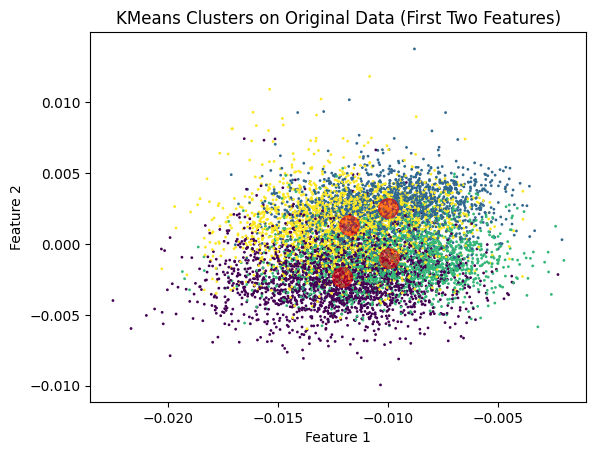

In [14]:
arr = movements
# Apply KMeans clustering with k=5
kmeans = KMeans(n_clusters=4)
kmeans.fit(arr)
centers = kmeans.cluster_centers_
labels = kmeans.labels_

# Scatter plot of the original data
# The first two features (columns) are used for plotting
plt.scatter(arr[:, 0], arr[:, 1], c=labels, cmap='viridis',s=1)

# Plotting the centroids
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200,cmap='ranbow', alpha=0.5)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('KMeans Clusters on Original Data (First Two Features)')

# Display the plot
plt.show()


## DBSCAN

Number of clusters: 13


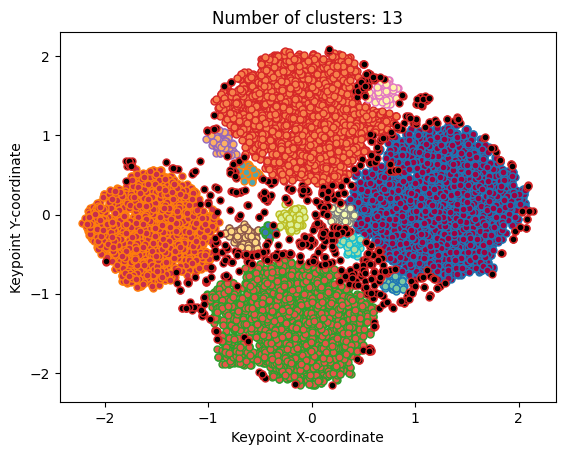

In [61]:
import numpy as np
from sklearn.cluster import DBSCAN

# Generate sample keypoints (random data for demonstration)
# Perform DBSCAN clustering
db = DBSCAN(eps=0.098, min_samples30).fit(Y_scaled)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f'Number of clusters: {n_clusters}')

# Plot the clusters
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for label, color in zip(unique_labels, colors):
    if label == -1:
        # Black used for noise
        color = [0, 0, 0, 1]

    class_member_mask = (labels == label)
    xy = Y_scaled[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(color),
             markersize=5)

plt.title(f'Number of clusters: {n_clusters}')
plt.xlabel('Keypoint X-coordinate')
plt.ylabel('Keypoint Y-coordinate')
plt.show()
# Assume 'labels' is the array you got from DBSCAN clustering
np.save('dbscan_labels.npy', labels)  # Saves the labels array to dbscan_labels.npy



In [10]:
from sklearn.neighbors import KNeighborsClassifier
# Check the unique clusters formed
print("Clusters found:", set(labels))

# Filtering out noise points
mask = labels != -1
X_filtered = map_t_array[mask]
clusters_filtered = labels[mask]

# Create and train KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_filtered, clusters_filtered)
#-0.22536589  0.36383697
#[[0.05043132, 0.5983906 ]]
new_data_point = np.array([-0.06751169  ,0.5088365 ])

predict_knn = knn.predict(np.array([[-0.06751169,  0.5088365 ]]))

print(predict_knn)

Clusters found: {0, 1, 2, -1}
[2]


In [81]:
# Plot training data
plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(labels)):
    plt.scatter(map_t[labels == label, 0], marker=[labels == label, 1], label=f'Class {label}')

# Plot new data point
plt.scatter(new_data_point[0], new_data_point[1], color='red', label='New Data Point', edgecolor='black', s=100)

# Adding labels and title
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Training Data and New Data Point')
plt.legend()

# Show plot
plt.show()

NameError: name 'map_t' is not defined

<Figure size 800x600 with 0 Axes>

## meanshift

Number of clusters: 3


/tmp/ipykernel_9963/1096802782.py:29: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='b', s=100, edgecolor='k', marker='x', label='Centers')


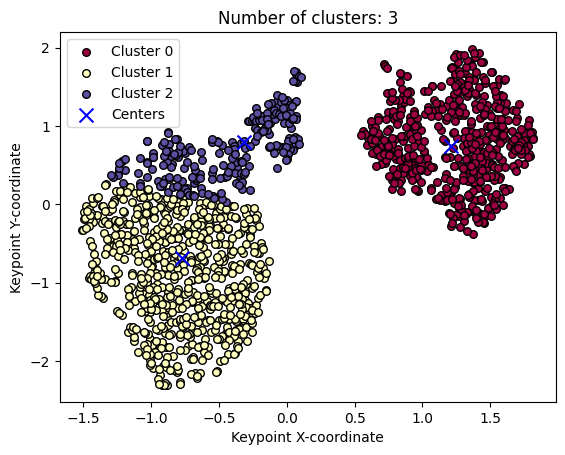

In [36]:
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import pairwise_distances_argmin


# Estimate the bandwidth (radius of the window for clustering)
bandwidth = estimate_bandwidth(Y_scaled, quantile=0.18, n_samples=50)

# Perform MeanShift clustering
mean_shift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
mean_shift.fit(Y_scaled)
labels = mean_shift.labels_
cluster_centers = mean_shift.cluster_centers_

# Number of clusters in labels
n_clusters = len(np.unique(labels))
print(f'Number of clusters: {n_clusters}')

# Plot the clusters
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
marker_size = 30 # Adjust the marker size as needed

for label, color in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = Y_scaled[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[tuple(color)], edgecolor='k', s=marker_size, label=f'Cluster {label}')

# Plot the cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='b', s=100, edgecolor='k', marker='x', label='Centers')

plt.title(f'Number of clusters: {n_clusters}')
plt.xlabel('Keypoint X-coordinate')
plt.ylabel('Keypoint Y-coordinate')
plt.legend()
plt.show()


## spectralcluster

/home/wetu/anaconda3/envs/yolov7/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


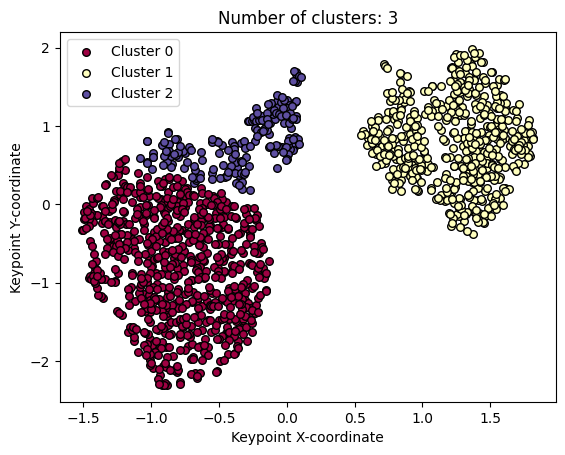

In [37]:
from sklearn.cluster import SpectralClustering
from sklearn.ensemble import RandomForestClassifier
# Perform Spectral Clustering
n_clusters = 3  # You can adjust the number of clusters here
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', assign_labels='kmeans')
labels = spectral_clustering.fit_predict(Y_scaled)
clf = RandomForestClassifier(random_state=42)
clf.fit(Y_scaled, labels)
# Plot the clusters
unique_labels = np.unique(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
marker_size = 30  # Adjust the marker size as needed

for label, color in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = Y_scaled[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[tuple(color)], edgecolor='k', s=marker_size, label=f'Cluster {label}')

plt.title(f'Number of clusters: {n_clusters}')
plt.xlabel('Keypoint X-coordinate')
plt.ylabel('Keypoint Y-coordinate')
plt.legend()
plt.show()


/home/wetu/anaconda3/envs/yolov7/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


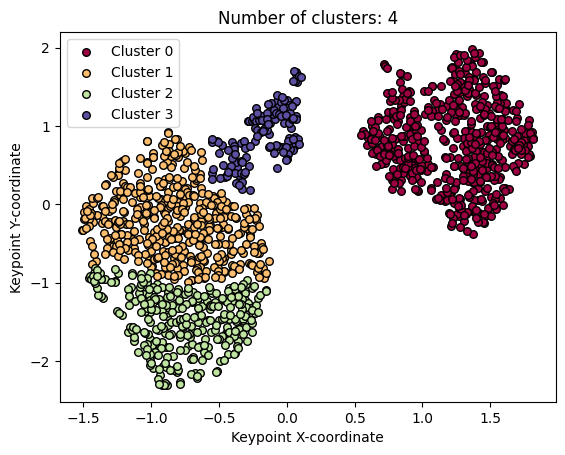

In [39]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

# Perform Agglomerative Clustering
n_clusters = 4  # You can adjust the number of clusters here
agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
labels = agglomerative_clustering.fit_predict(Y_scaled)

# Plot the clusters
unique_labels = np.unique(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
marker_size = 30  # Adjust the marker size as needed

for label, color in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = Y_scaled[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[tuple(color)], edgecolor='k', s=marker_size, label=f'Cluster {label}')

plt.title(f'Number of clusters: {n_clusters}')
plt.xlabel('Keypoint X-coordinate')
plt.ylabel('Keypoint Y-coordinate')
plt.legend()
plt.show()


In [40]:
from sklearn.svm import SVC
n_clusters = 4  # You can adjust the number of clusters here
agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
labels = agglomerative_clustering.fit_predict(movements)
svm = SVC(kernel='rbf', C=1.0)  # You can adjust C and other parameters as needed
svm.fit(movements, labels)

/home/wetu/anaconda3/envs/yolov7/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


SVC()

In [41]:
import cv2
import mediapipe as mp
import torch

mp_holistic = mp.solutions.holistic
video_path = "/home/wetu/bmo/Computer_Vision/video_reconstruct/test.mp4"  # Replace with your video path

# Initialize video capture
cap = cv2.VideoCapture(video_path)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640, 480))
model.to(device)
# Initialize variables
keypoint_sequence = []
sequence_length = 40  # Length of each sequence of keypoints
current_cluster = 0
# Initialize MediaPipe Holistic and your encoder model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # Exit if no frame is read

        # Process frame to extract keypoints
        image, results = mediapipe_detection(frame, holistic)  # Assuming this function is defined
        image = draw_styled_landmarks(image, results)
        keypoints = extract_keypoints(results)  # Extract keypoints
        keypoint_sequence.append(keypoints)  # Add extracted keypoints to the sequence

        # Check if sequence is ready
        if len(keypoint_sequence) == sequence_length:
            # Convert sequence to tensor and reshape as needed
            
            sequence_tensor = torch.stack([torch.tensor((kp),dtype=torch.float) for kp in keypoint_sequence])
            sequence_tensor = sequence_tensor.reshape(-1, sequence_length, input_size).to(device)

            # Pass sequence through the encoder
            encoded_output, hidd = model.encoder(sequence_tensor.float())
            
            # Use your trained k-means model to classify the encoded sequence
            kmeans_prediction = kmeans.predict(hidd.cpu().detach().numpy())
            current_cluster = kmeans_prediction[0]
            # Process the prediction as needed...

            # Reset the sequence
            keypoint_sequence = []
        cv2.putText(image, f'Cluster: {current_cluster}', (50, 50), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        # Show video
        cv2.imshow('Processed Feed', image)
        out.write(image)
        print()
        # Break the loop if 'q' is pressed
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()


QObject::moveToThread: Current thread (0x61802169bec0) is not the object's thread (0x61802157e260).
Cannot move to target thread (0x61802169bec0)

QObject::moveToThread: Current thread (0x61802169bec0) is not the object's thread (0x61802157e260).
Cannot move to target thread (0x61802169bec0)

QObject::moveToThread: Current thread (0x61802169bec0) is not the object's thread (0x61802157e260).
Cannot move to target thread (0x61802169bec0)

QObject::moveToThread: Current thread (0x61802169bec0) is not the object's thread (0x61802157e260).
Cannot move to target thread (0x61802169bec0)

QObject::moveToThread: Current thread (0x61802169bec0) is not the object's thread (0x61802157e260).
Cannot move to target thread (0x61802169bec0)

QObject::moveToThread: Current thread (0x61802169bec0) is not the object's thread (0x61802157e260).
Cannot move to target thread (0x61802169bec0)

QObject::moveToThread: Current thread (0x61802169bec0) is not the object's thread (0x61802157e260).
Cannot move to tar

KeyboardInterrupt: 

In [14]:
import cv2
import mediapipe as mp
import torch


# Setup MediaPipe and video processing
mp_holistic = mp.solutions.holistic
video_path = "/home/wetu/bmo/Computer_Vision/video_reconstruct/test.mp4"
cap = cv2.VideoCapture(video_path)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640, 480))
model.to(device)
new_cluster = None
keypoint_sequence = []
sequence_length = 40  # Length of each sequence of keypoints
current_cluster = None

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Process frame to extract keypoints
        image, results = mediapipe_detection(frame, holistic)
        image = draw_styled_landmarks(image, results)
        keypoints = extract_keypoints(results)
        keypoint_sequence.append(keypoints)

        if len(keypoint_sequence) == sequence_length:
            # Stack the keypoints into a tensor
            
            sequence_tensor = torch.stack([torch.tensor((kp),dtype=torch.float) for kp in keypoint_sequence])
            sequence_tensor = sequence_tensor.reshape(-1, sequence_length, input_size).to(device)
            # Encode the keypoints sequence using the model

            encoded_output, hidd = model.encoder(sequence_tensor.float())
            hidd_numpy = hidd.detach().cpu().numpy()  # Detach, move to CPU, and convert to NumPy
            hidd_scal = scaler_x.transform(hidd_numpy)
            projector = nnmodel.predict(hidd_scal)
            # Check the statistics of hidd before scalin

            #print(f'hidd scak {tensor_scarl[:6]}, projector{projector}')
            new_cluster = kmeans.predict(hidd_numpy)[0]
            #new_cluster = knn.predict(projector)[0]  # Get the first cluster from predictions
            #new_cluster = pairwise_distances_argmin(projector, mean_shift.cluster_centers_)[0]
            #new_cluster = clf.predict(projector)[0]
            #new_cluster = svm.predict(hidd_numpy)[0]

            # Reset the sequence for the next round of data
            keypoint_sequence = []

        # Display cluster on the video frame
        cv2.putText(image, f'Cluster: {new_cluster}', (50, 50), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.imshow('Processed Feed', image)
        out.write(image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
out.release()
cv2.destroyAllWindows()


QObject::moveToThread: Current thread (0x568aaf41a840) is not the object's thread (0x568af946b1e0).
Cannot move to target thread (0x568aaf41a840)

QObject::moveToThread: Current thread (0x568aaf41a840) is not the object's thread (0x568af946b1e0).
Cannot move to target thread (0x568aaf41a840)

QObject::moveToThread: Current thread (0x568aaf41a840) is not the object's thread (0x568af946b1e0).
Cannot move to target thread (0x568aaf41a840)

QObject::moveToThread: Current thread (0x568aaf41a840) is not the object's thread (0x568af946b1e0).
Cannot move to target thread (0x568aaf41a840)

QObject::moveToThread: Current thread (0x568aaf41a840) is not the object's thread (0x568af946b1e0).
Cannot move to target thread (0x568aaf41a840)

QObject::moveToThread: Current thread (0x568aaf41a840) is not the object's thread (0x568af946b1e0).
Cannot move to target thread (0x568aaf41a840)

QObject::moveToThread: Current thread (0x568aaf41a840) is not the object's thread (0x568af946b1e0).
Cannot move to tar

1/1 [==============================] - 0s 18ms/step


## Testing

In [15]:
test_part = "/home/wetu/bmo/Thesis_Research/data/video/test/test_data/"
label_model = []
current_label = []
# Setup MediaPipe and video processing
mp_holistic = mp.solutions.holistic

keypoint_sequence = []
sequence_length = 40  # Length of each sequence of keypoints
current_cluster = None
model.to(device)

AutoEncoderRNN(
  (encoder): EncoderRNN(
    (lstm): LSTM(66, 32, num_layers=2, batch_first=True, dropout=0.2)
    (relu): ReLU()
  )
  (decoder): DecoderRNN(
    (lstm): LSTM(32, 66, num_layers=2, batch_first=True, dropout=0.2)
  )
)

In [34]:

label_model = []
for path in os.listdir(test_part):
    video_paths = os.path.join(test_part, path)
    for video_path in os.listdir(video_paths):
        full_video_path = os.path.join(video_paths, video_path)
        cap = cv2.VideoCapture(full_video_path)
        if not cap.isOpened():
            print(f"Failed to open video: {full_video_path}")
            continue  # Skip this video and move to the next one

        with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    print(f"No more frames or failed to read from: {full_video_path}")
                    break
                # Process frame to extract keypoints
                image, results = mediapipe_detection(frame, holistic)
                image = draw_styled_landmarks(image, results)
                keypoints = extract_keypoints(results)
                keypoint_sequence.append(keypoints)
                if len(keypoint_sequence) == sequence_length:
                    # Stack the keypoints into a tensor
                    sequence_tensor = torch.stack([torch.tensor(kp, dtype=torch.float) for kp in keypoint_sequence])
                    sequence_tensor = sequence_tensor.reshape(-1, sequence_length, input_size).to(device)
                    # Encode the keypoints sequence using the model
                    encoded_output, hidd = model.encoder(sequence_tensor.float())
                    hidd_numpy = hidd.detach().cpu().numpy()  # Detach, move to CPU, and convert to NumPy
                    hidd_scal = scaler_x.transform(hidd_numpy)
                    projector = nnmodel.predict(hidd_scal)
                    # Check the statistics of hidd before scalin

                    #print(f'hidd scak {tensor_scarl[:6]}, projector{projector}')
                    new_cluster = kmeans.predict(hidd_numpy)[0]
                    #new_cluster = knn.predict(projector)[0]  # Get the first cluster from predictions
                    #new_cluster = pairwise_distances_argmin(projector, mean_shift.cluster_centers_)[0]
                    #new_cluster = clf.predict(projector)[0]
                    #new_cluster = svm.predict(hidd_numpy)[0]
                    print(new_cluster)
                    keypoint_sequence = []
                    current_label.append(new_cluster)
                    print(f"Detected new cluster: {new_cluster}")

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

        cap.release()
        cv2.destroyAllWindows()
        label_model.append(current_label)
        print(f"Labels for {video_path}: {current_label}")  # Print the labels for each video
        current_label = []  # Reset for the next video


1/1 [==============================] - 0s 20ms/step
1
Detected new cluster: 1
1/1 [==============================] - 0s 24ms/step
2
Detected new cluster: 2
No more frames or failed to read from: /home/wetu/bmo/Thesis_Research/data/video/test/test_data/pickup/vlc-record-2024-05-28-20h56m02s-merged_output.mp4-.mp4
Labels for vlc-record-2024-05-28-20h56m02s-merged_output.mp4-.mp4: [1, 2]
1/1 [==============================] - 0s 19ms/step
2
Detected new cluster: 2
1/1 [==============================] - 0s 19ms/step
2
Detected new cluster: 2
No more frames or failed to read from: /home/wetu/bmo/Thesis_Research/data/video/test/test_data/pickup/vlc-record-2024-05-28-21h32m19s-merged_output.mp4-.mp4
Labels for vlc-record-2024-05-28-21h32m19s-merged_output.mp4-.mp4: [2, 2]
1/1 [==============================] - 0s 22ms/step
2
Detected new cluster: 2
No more frames or failed to read from: /home/wetu/bmo/Thesis_Research/data/video/test/test_data/pickup/vlc-record-2024-05-28-21h01m31s-merged_outp

In [35]:
print(len(label_model))

36


In [19]:
from collections import Counter

# Find the most common number in each sublist
most_common_numbers = [Counter(sublist).most_common(1)[0][0] for sublist in label_model]

print(most_common_numbers)

[2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0, 1, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [36]:
label = [1 if i == 0 else i for i in most_common_numbers]

In [24]:
print(label)

[2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [27]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np


# Convert list to numpy array and reshape for OneHotEncoder
#label_array = np.array(most_common_numbers).reshape(-1, 1)
label_array = np.array(label).reshape(-1,1)
# Create the OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit and transform the data
encoded_labels = encoder.fit_transform(label_array)

print(encoded_labels)


[[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


/home/wetu/anaconda3/envs/yolov7/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [30]:
import numpy as np

# Define each segment with float type explicitly
first_segment = np.tile([0.0, 1.0, 0.0], (12, 1))  # Repeats [1.0, 0.0, 0.0] for 12 rows
second_segment = np.tile([0.0, 0.0, 1.0], (12, 1)) # Repeats [0.0, 0.0, 1.0] for 12 rows
third_segment = np.tile([1.0, 0.0, 0.0], (12, 1))  # Repeats [0.0, 1.0, 0.0] for 12 rows

# Concatenate all segments to form the final matrix
final_matrix = np.vstack((first_segment, second_segment, third_segment))

print(final_matrix)
print()
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]



In [29]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

true_labels_flat = np.argmax(final_matrix, axis=1)
predicted_labels_flat = np.argmax(encoded_labels, axis=1)

# Calculating metrics
accuracy = accuracy_score(true_labels_flat, predicted_labels_flat)
recall = recall_score(true_labels_flat, predicted_labels_flat, average='macro')
precision = precision_score(true_labels_flat, predicted_labels_flat, average='macro')
f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

Accuracy: 0.7777777777777778
Recall: 0.7777777777777778
Precision: 0.8666666666666667
F1 Score: 0.7813283208020049
